# CPSC 340: Fundamentals of Learning (demo)
2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [12]:
using PyCall
SkDatasets = pyimport("sklearn.datasets")
using PyPlot
plt = pyimport("matplotlib.pyplot")
SkTree = pyimport("sklearn.tree")
using Statistics

### The handwritten digits data set

Load the handwritten digits data set and display one example:

In [5]:
digits = SkDatasets.load_digits()
X, y = digits["data"], digits["target"]
n, d = size(X)
println("n= ",n)
println("d= ",d)

n= 1797
d= 64


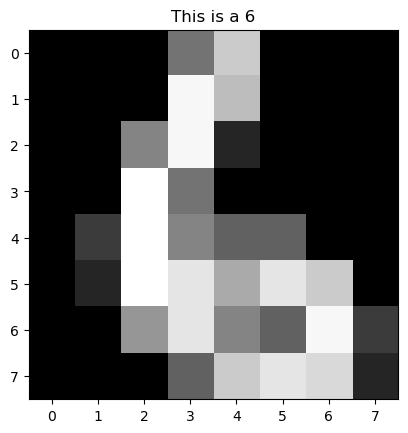

In [27]:
idx = rand(1:n) 
plt.imshow(digits["images"][idx,:,:], cmap="Greys_r")
val = digits["target"][idx]
plt.title("This is a $val");

### Some EDA on feature and target values

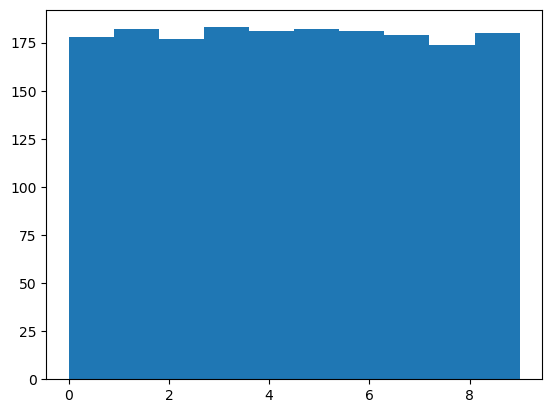

In [28]:
plt.hist(y);

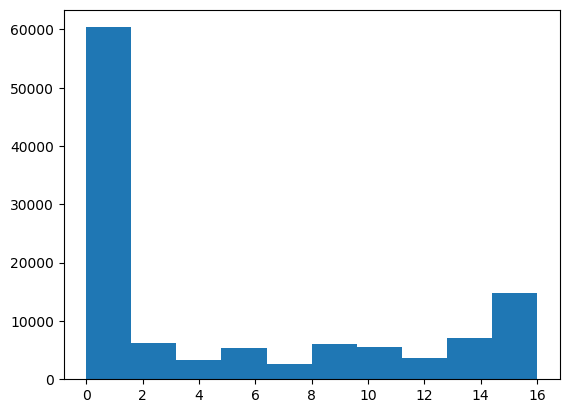

In [30]:
plt.hist(X'[:]);

### Decision stump (depth=1)

In [6]:
stump = SkTree.DecisionTreeClassifier(max_depth=1)
stump.fit(X,y);

In [ ]:
# from sklearn.tree import export_graphviz
# import graphviz # requires `conda install graphviz` and `pip install graphviz`

# graphviz.Source(export_graphviz(stump, out_file=None, class_names=digits.target_names.astype(str), impurity=False))

In [7]:
yhat = stump.predict(X)
print("Error rate: ", sum(convert(Array{Int64},y.!=yhat))/n) # or np.mean(y!=yhat)

Error rate: 0.80189204229271

(Random guessing would get us an error rate of 0.9.)

### Decision tree (depth=2)

In [8]:
tree = SkTree.DecisionTreeClassifier(max_depth=2)
tree.fit(X,y)

# graphviz.Source(export_graphviz(tree, out_file=None, class_names=digits.target_names.astype(str), impurity=False))

PyObject DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [9]:
yhat = tree.predict(X)
print("Error rate: ", sum(convert(Array{Int64},y.!=yhat))/n) # or np.mean(y!=yhat)

Error rate: 0.6811352253756261

In [10]:
tree = SkTree.DecisionTreeClassifier(max_depth=100)
tree.fit(X,y)
yhat = tree.predict(X)
print("Error rate: ", sum(convert(Array{Int64},y.!=yhat))/n) # or np.mean(y!=yhat)
# graphviz.Source(export_graphviz(tree, out_file=None, class_names=digits.target_names.astype(str), impurity=False))

Error rate: 0.0

### How does error rate change vs. depth?

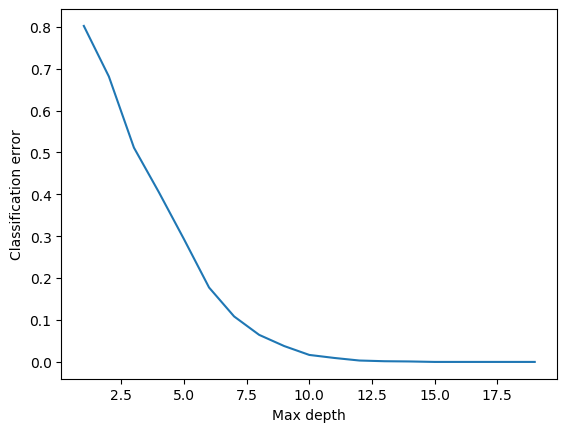

In [13]:
errors = []
depths = 1:19
for max_depth in depths
    tree = SkTree.DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X,y)
    yhat = tree.predict(X)
    push!(errors,Statistics.mean(convert(Array{Int64},y.!=yhat)))
end
plt.plot(depths, errors)
plt.xlabel("Max depth")
plt.ylabel("Classification error");

In [14]:
errors[end]

0.0

### Overfitting

- With this decision tree, "training accuracy" is 1.
- It perfectly labels the data we used to make the tree.
- We are now given features for 100 new digits.
- What is the "testing accuracy" on the new data?
- How does it do on data not used to make the tree?

In [16]:
include("__init__.jl") #from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,at=0.8)

tree = SkTree.DecisionTreeClassifier(max_depth=20)
tree.fit(Xtrain,ytrain)
yhat = tree.predict(Xtrain)
train_err = Statistics.mean(convert(Array{Int64},ytrain.!=yhat))
print("Training error, ", train_err)

Training error, 0.0

In [17]:
yhat = tree.predict(Xtest)
train_err = Statistics.mean(convert(Array{Int64},ytest.!=yhat))
print("Test error, ", train_err)

Test error, 0.16434540389972144

- Overfitting: lower accuracy on new data.
- Our rules got too specific to our exact training dataset.


### Training vs. test error

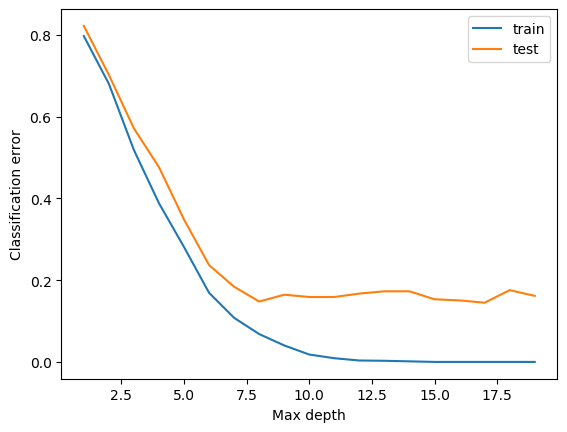

In [18]:
train_errors = []
test_errors = []
for max_depth in depths
    tree = SkTree.DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(Xtrain,ytrain)
    push!(train_errors, Statistics.mean(convert(Array{Int64},ytrain.!=tree.predict(Xtrain))))
    push!(test_errors, Statistics.mean(convert(Array{Int64},ytest.!=tree.predict(Xtest))))
end
plt.plot(depths, train_errors, label="train")
plt.plot(depths, test_errors, label="test")
plt.xlabel("Max depth")
plt.ylabel("Classification error")
plt.legend();